In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Changing the format in which the 'describe' API returns data information. 
# Scientific notation is not very useful for a quick overview
# Credit to Stack Overflow here: 
# https://stackoverflow.com/questions/21137150/format-suppress-scientific-notation-from-python-pandas-aggregation-results/21140339
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Loading 10M rows to create an overview of the data
NUM_ROWS = 10000000

In [4]:
train_df = pd.read_csv('../dataset/train.csv', nrows=NUM_ROWS)

In [5]:
# Since the value of key is unique and is of no use in the final prediction. Removing it from the data
# processing to use it as key
train_df.set_index('key', drop=True, inplace=True)

In [6]:
# Fetching the names of the columns that are present in the data
columns = train_df.columns

# Getting the count to see if the correct amout of data was retrieved
# Also getting the dtypes of each column to get an idea of the data
train_df.count(), train_df.dtypes

(fare_amount          10000000
 pickup_datetime      10000000
 pickup_longitude     10000000
 pickup_latitude      10000000
 dropoff_longitude     9999931
 dropoff_latitude      9999931
 passenger_count      10000000
 dtype: int64, fare_amount          float64
 pickup_datetime       object
 pickup_longitude     float64
 pickup_latitude      float64
 dropoff_longitude    float64
 dropoff_latitude     float64
 passenger_count        int64
 dtype: object)

In [7]:
# Points to note
#    -> something's off with dropoff_longitude and dropoff_latitide
# scan for null or missing values in both columns
train_df.isnull().any()

fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

In [8]:
# for sure there are null values in the dropoff_longitude and dropoff_latitude
# These do not seem to be data in which null values can be substituted.
# Removing these value for now, will come to it later.
null_value_columns = ['dropoff_longitude', 'dropoff_latitude']

#fetching indexes to be dropped
drop_index_longitude = train_df[train_df['dropoff_longitude'].isnull()].index
drop_index_latitude = train_df[train_df['dropoff_latitude'].isnull()].index
drop_indexes = np.array(list(set(drop_index_longitude).union(set(drop_index_latitude))))
drop_indexes

array(['2012-12-11 10:14:13.0000004', '2012-12-11 11:45:18.0000004',
       '2012-12-11 12:41:09.0000002', '2013-11-15 07:35:14.0000002',
       '2013-06-03 19:25:13.0000001', '2011-03-03 11:06:46.0000001',
       '2011-06-20 11:15:44.0000003', '2013-06-22 03:48:41.0000002',
       '2013-11-13 10:53:50.0000001', '2012-12-11 12:50:52.00000010',
       '2013-11-05 09:42:21.0000003', '2012-12-11 12:20:25.0000004',
       '2011-12-20 14:17:30.0000001', '2013-10-16 22:31:33.0000004',
       '2012-07-18 13:59:42.0000003', '2012-12-11 13:05:09.0000003',
       '2013-11-05 22:08:03.0000007', '2013-12-15 00:59:51.0000003',
       '2013-06-03 19:19:27.0000004', '2013-10-10 07:48:01.0000002',
       '2011-09-08 09:12:52.0000001', '2013-12-08 02:27:17.0000004',
       '2013-09-05 00:02:14.0000003', '2013-11-04 20:07:59.0000006',
       '2012-12-11 11:25:07.0000007', '2013-03-14 10:22:15.0000003',
       '2013-06-20 20:55:19.0000002', '2010-10-12 18:12:40.0000003',
       '2012-12-11 12:12:15.00000

In [9]:
train_df.drop(drop_indexes, inplace=True)
train_df.count()

fare_amount          9999931
pickup_datetime      9999931
pickup_longitude     9999931
pickup_latitude      9999931
dropoff_longitude    9999931
dropoff_latitude     9999931
passenger_count      9999931
dtype: int64

In [10]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999931.000,9999931.000,9999931.000,9999931.000,9999931.000,9999931.000
mean,11.338,-72.508,39.919,-72.509,39.919,1.685
std,9.800,12.994,9.323,12.875,9.237,1.323
min,-107.750,-3439.245,-3492.264,-3426.601,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3457.626,3344.459,3457.622,3351.403,208.000


In [11]:
# looking at the passenger_count column, it seems bizzare that a cab had 208 passengers.
# let's see what the distribution over passenger count looks like
train_df.groupby('passenger_count')['passenger_count'].count()

passenger_count
0        35263
1      6917305
2      1476610
3       439133
4       212015
5       707721
6       211867
7            2
9            3
49           1
51           1
129          1
208          9
Name: passenger_count, dtype: int64

In [12]:
# Since multiple cab rides are reporting the exact same number of extreme passenger count, 
# it seems like there might be two possibilities: 
#    1. These are outlires that were generated from the same taxi due to some technical fault
#    2. The data might be referring to some special taxi ( or a bus ) that would be able to seat more than 6 people.
# Either way, these are anomalies and might end up skewing are result. It should
# be safe to ignore these values for now.
drop_indexes = train_df[train_df.passenger_count > 6].index
train_df.drop(drop_indexes, inplace=True)
train_df.groupby('passenger_count')['passenger_count'].count()

passenger_count
0      35263
1    6917305
2    1476610
3     439133
4     212015
5     707721
6     211867
Name: passenger_count, dtype: int64

In [13]:
# Looking at the summary of the dataframe once again: 
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999914.000,9999914.000,9999914.000,9999914.000,9999914.000,9999914.000
mean,11.338,-72.508,39.919,-72.509,39.919,1.685
std,9.800,12.994,9.322,12.860,9.237,1.308
min,-107.750,-3439.245,-3492.264,-3426.601,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3457.626,3344.459,3457.622,3351.403,6.000


In [14]:
# The passenger count also contains the value 0 for about .35 percent of the entries.
# The entry count ( around 35000 ) does not seem to be small enough that it can be 
# ignored without a second thought, and
# it could be encoding a special meaning, like the driver driving around looking for rides
# let's keep it as is for now. We'll revisit this later.

In [15]:
# Another column that looks interesting is fare_amount. From the first look
# it looks like it might contain a negative values, which does not make sense. let's have a
# deeper look into the data to figure out what might be going on here. 

#Let's start with getting the number of entries with a negetive fare_amount
neg_fare_df = train_df[train_df.fare_amount < 0.0]
neg_fare_df.count()

fare_amount          420
pickup_datetime      420
pickup_longitude     420
pickup_latitude      420
dropoff_longitude    420
dropoff_latitude     420
passenger_count      420
dtype: int64

In [16]:
# 420 does not seem to be that significant a number considering the size of the sample set. 
# should be safe to ignore, but let's still explore the data a little further to see if the 
# negative value might hold some special significance or pattern that might be important to us

neg_fare_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2010-03-09 23:37:10.0000005,-2.900,2010-03-09 23:37:10 UTC,-73.789,40.643,-73.789,40.642,1
2015-03-22 05:14:27.0000001,-2.500,2015-03-22 05:14:27 UTC,-74.000,40.721,-74.000,40.721,1
2013-08-30 08:57:10.0000002,-3.000,2013-08-30 08:57:10 UTC,-73.995,40.741,-73.996,40.741,4
2013-08-11 13:39:10.0000001,-2.500,2013-08-11 13:39:10 UTC,-73.785,40.648,0.000,0.000,1
2015-04-30 15:19:45.0000003,-2.500,2015-04-30 15:19:45 UTC,-73.952,40.790,-73.950,40.793,1


In [17]:
neg_fare_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,420.000,420.000,420.000,420.000,420.000,420.000
mean,-9.288,-69.033,38.031,-67.975,37.448,1.848
std,15.072,18.472,10.177,20.198,11.127,1.433
min,-107.750,-74.230,0.000,-74.230,0.000,0.000
25%,-6.200,-73.990,40.727,-73.989,40.725,1.000
50%,-3.500,-73.976,40.753,-73.974,40.750,1.000
75%,-2.500,-73.951,40.765,-73.943,40.764,2.000
max,-0.010,0.000,40.919,0.000,40.919,6.000


In [18]:
# dropping negative fare amounts because they make no sense. 
drop_indexes = neg_fare_df.index
train_df.drop(drop_indexes, inplace=True)

In [19]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999494.000,9999494.000,9999494.000,9999494.000,9999494.000,9999494.000
mean,11.339,-72.508,39.919,-72.509,39.919,1.685
std,9.799,12.994,9.322,12.859,9.237,1.308
min,0.000,-3439.245,-3492.264,-3426.601,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3457.626,3344.459,3457.622,3351.403,6.000


In [20]:
import itertools
columns = [('_').join(x) for x in itertools.product(['pickup', 'dropoff'], ['latitude', 'longitude'])]
columns

['pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude']

In [21]:
outliers = []
for column in columns:
    outliers.extend(train_df[(train_df[column] < -180.0) | (train_df[column] > 180.0)].index)

len(set(outliers))    # total number of data points that are outside the specified range for lat. and long.

472

In [22]:
# The value of latitude (assuming it's in degrees due to the lack of any information) should be in 
# the range -180 to 180. A minimum value of 3439 and maximum value of 3457 is weird. 
# Assumption: something went wrong in the GPS collecting the data. This can be corrected using 
# median value of the data, but since the number of datapoints are so less, it won't make too much
# of a difference here. dropping the points seems like a quicker appraoch.

for column in columns:
    drop_indexes = train_df[(train_df[column] < -180.0) | (train_df[column] > 180.0)].index
    train_df.drop(drop_indexes, inplace=True)

train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000
mean,11.339,-72.496,39.916,-72.500,39.918,1.685
std,9.799,10.464,6.123,10.448,6.117,1.308
min,0.000,-168.604,-74.824,-173.342,-74.193,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,154.101,91.267,154.101,94.617,6.000


In [23]:
train_df[train_df.passenger_count == 0].count()

fare_amount          35262
pickup_datetime      35262
pickup_longitude     35262
pickup_latitude      35262
dropoff_longitude    35262
dropoff_latitude     35262
passenger_count      35262
dtype: int64

In [24]:
# Haversine algorithm for calculating distance with given latitude and longitude
# copied from stack overflow: 
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

In [25]:
train_df['distance'] = train_df[columns].apply(lambda x: haversine(*x), axis=1)

train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000
mean,11.339,-72.496,39.916,-72.500,39.918,1.685,12.049
std,9.799,10.464,6.123,10.448,6.117,1.308,234.333
min,0.000,-168.604,-74.824,-173.342,-74.193,0.000,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000,0.509
50%,8.500,-73.982,40.753,-73.980,40.753,1.000,0.946
75%,12.500,-73.967,40.767,-73.964,40.768,2.000,1.742
max,1273.310,154.101,91.267,154.101,94.617,6.000,8486.451


In [26]:
train_df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
distance             float64
dtype: object

"\n    Summary of the graph: \n        Issue1. It looks like except a few points, the fare_function is not dependent on the distance at all.\n        Reason: 1. The distance calculating function might have a bug \n                2. The latitude/longitude values don't have correct info.\n                3. The points are so close that the graph does not make sense. \n                4. The vertical rise in the fare_amount are outliers that will interfere with the prediction \n                    - these need to be sorted.\n"

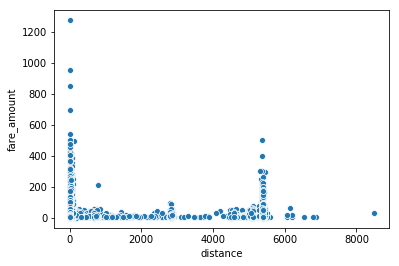

In [27]:
# plotting a scatter plot to see how fare varies with distance

sns.scatterplot(train_df['distance'], train_df['fare_amount'])

# This does not make sense...or the plot is not correct.
"""
    Summary of the graph: 
        Issue1. It looks like except a few points, the fare_function is not dependent on the distance at all.
        Reason: 1. The distance calculating function might have a bug 
                2. The latitude/longitude values don't have correct info.
                3. The points are so close that the graph does not make sense. 
                4. The vertical rise in the fare_amount are outliers that will interfere with the prediction 
                    - these need to be sorted.
"""

In [28]:
# Dealing with Issue 1:
# Cleaning up distance function - looking at latitude longitude values

train_df[columns + ['distance']].describe(np.linspace(0,1,101))

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
count,9999022.000,9999022.000,9999022.000,9999022.000,9999022.000
mean,39.916,-72.496,39.918,-72.500,12.049
std,6.123,10.464,6.117,10.448,234.333
min,-74.824,-168.604,-74.193,-173.342,0.000
0%,-74.824,-168.604,-74.193,-173.342,0.000
1%,0.000,-74.014,0.000,-74.015,0.000
2%,40.590,-74.010,40.576,-74.012,0.000
3%,40.645,-74.009,40.647,-74.010,0.001
4%,40.681,-74.008,40.673,-74.008,0.096
5%,40.702,-74.007,40.687,-74.007,0.141


In [29]:
# from the above data, dropping values that do not belong to the below range
# 40.0 <= pickup_latitude <= 41
# -74.0 <= pickup_longitude <= -73.0
# 40.0 <= drop_latitude <= 41 
# -74.0 <= drop_longitude <= -73.0

column_ll = dict(zip(columns, [40.0, -74.2, 40.0, -74.2])) # lower limit
column_ul = dict(zip(columns, [41.0, -73.0, 41.0, -73.0])) # upper limit

drop_index = set()
for column in columns:
    temp = train_df[(train_df[column] <= column_ll[column]) | (train_df[column] >= column_ul[column])]
    drop_index = drop_index.union(set(temp.index))

In [30]:
len(drop_index)

218448

In [31]:
# dropping the indexes. A better way would be to handle the zero values seperately, but with the amount of 
# data this should not majorly affect the prediction of fare_amount

train_df.drop(drop_index, inplace=True)

In [32]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9780574.000,9780574.000,9780574.000,9780574.000,9780574.000,9780574.000,9780574.000
mean,11.300,-73.975,40.751,-73.974,40.751,1.685,1.668
std,9.550,0.035,0.027,0.035,0.031,1.308,2.330
min,0.000,-74.200,40.005,-74.200,40.004,0.000,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000,0.530
50%,8.500,-73.982,40.753,-73.981,40.754,1.000,0.963
75%,12.500,-73.968,40.768,-73.965,40.768,2.000,1.755
max,952.000,-73.000,41.000,-73.001,41.000,6.000,67.265


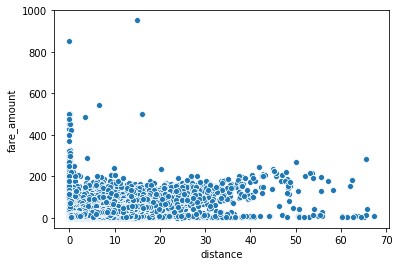

In [33]:
sns.scatterplot(train_df.distance, train_df.fare_amount)

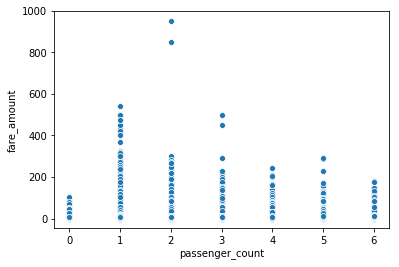

In [34]:
sns.scatterplot(train_df.passenger_count, train_df.fare_amount)

In [35]:
pd.DataFrame.corr(train_df).fare_amount

fare_amount          1.000
pickup_longitude     0.423
pickup_latitude     -0.215
dropoff_longitude    0.315
dropoff_latitude    -0.175
passenger_count      0.015
distance             0.831
Name: fare_amount, dtype: float64

In [40]:
date_time_df = train_df.pickup_datetime.str.split(expand=True)

In [46]:
train_df['time'] = pd.to_datetime(date_time_df[1], format="%H:%M:%S").dt.time

In [49]:
train_df['time'] = train_df['time'].dt.time

In [53]:
train_df['time'].head()

key
2009-06-15 17:26:21.0000001      17:26:21
2010-01-05 16:52:16.0000002      16:52:16
2011-08-18 00:35:00.00000049     00:35:00
2012-04-21 04:30:42.0000001      04:30:42
2010-03-09 07:51:00.000000135    07:51:00
Name: time, dtype: object

In [56]:
x = pd.to_datetime(date_time_df[0], infer_datetime_format=True)

In [58]:
train_df['date'] = x

In [59]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time,date
key,,,,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1,0.255,17:26:21,2009-06-15
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1,2.874,16:52:16,2010-01-05
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2,0.622,00:35:00,2011-08-18
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1,0.565,04:30:42,2012-04-21
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1,0.845,07:51:00,2010-03-09


In [63]:
train_df.dtypes

fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distance                    float64
time                         object
date                 datetime64[ns]
dtype: object

In [68]:
train_df['datetime'] = pd.to_datetime(train_df.pickup_datetime, infer_datetime_format=True)

In [69]:
train_df['datetime'].head()

key
2009-06-15 17:26:21.0000001     2009-06-15 17:26:21
2010-01-05 16:52:16.0000002     2010-01-05 16:52:16
2011-08-18 00:35:00.00000049    2011-08-18 00:35:00
2012-04-21 04:30:42.0000001     2012-04-21 04:30:42
2010-03-09 07:51:00.000000135   2010-03-09 07:51:00
Name: datetime, dtype: datetime64[ns]

In [70]:
train_df.dtypes

fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distance                    float64
time                         object
date                 datetime64[ns]
datetime             datetime64[ns]
dtype: object

In [73]:
train_df.drop(['time', 'date'], inplace=True, axis=1)

In [97]:
# splitting date time to time of day range. this is to check if fare varies 
# with morning, noon, evening or night time
# morning -> [6:00, 12:00) -> 0
# afternoon -> [12:00, 5:00) -> 1
# evening -> [5:00, 10:00) -> 2
# night -> [10:00, 6:00] -> 4
from datetime import time as dt

def time_of_day(time):
    morning_start, morning_end = dt(6, 0, 0), dt(12, 0, 0)
    noon_start, noon_end = dt(12, 0, 0), dt(17, 0, 0)
    evening_start, evening_end = dt(17, 0, 0), dt(20, 0, 0)
    night_start, night_end = dt(20, 0, 0), dt(6, 0, 0)
    
    if morning_start <= time and time < morning_end:
        return 0
    elif noon_start <= time and time < noon_end:
        return 1
    elif evening_start <= time and time < evening_end:
        return 2
    elif night_start <= time or time < night_end:
        return 3

In [100]:
train_df['time_of_day'] = train_df.datetime.apply(lambda x: time_of_day(x.time()))

In [104]:
train_df.corr()['fare_amount']

fare_amount          1.000
pickup_longitude     0.423
pickup_latitude     -0.215
dropoff_longitude    0.315
dropoff_latitude    -0.175
passenger_count      0.015
distance             0.831
time_of_day          0.009
Name: fare_amount, dtype: float64

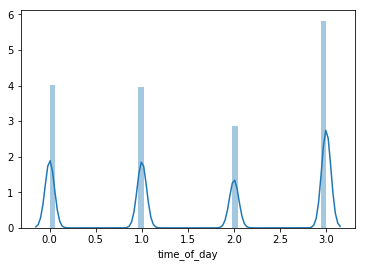

In [106]:
sns.distplot(train_df.time_of_day)

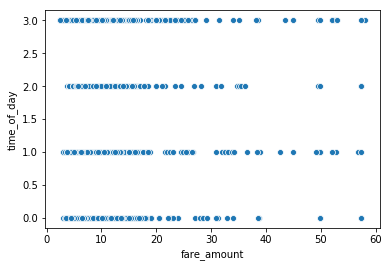

In [107]:
rf_plot = train_df.iloc[:1000]
sns.scatterplot(rf_plot.fare_amount, rf_plot.time_of_day)

In [108]:
train_df.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time_of_day
fare_amount,1.000,0.423,-0.215,0.315,-0.175,0.015,0.831,0.009
pickup_longitude,0.423,1.000,-0.045,0.319,0.043,0.001,0.494,-0.048
pickup_latitude,-0.215,-0.045,1.000,0.047,0.429,-0.008,-0.231,-0.111
dropoff_longitude,0.315,0.319,0.047,1.000,0.131,-0.001,0.408,0.012
dropoff_latitude,-0.175,0.043,0.429,0.131,1.000,-0.005,-0.144,-0.070
passenger_count,0.015,0.001,-0.008,-0.001,-0.005,1.000,0.011,0.038
distance,0.831,0.494,-0.231,0.408,-0.144,0.011,1.000,0.020
time_of_day,0.009,-0.048,-0.111,0.012,-0.070,0.038,0.020,1.000
